<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
criterion = nn.MSELoss()
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/WI_AE_v2/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_mel_numpy"):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_mel_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_mel_numpy"):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_mel_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

,Images,songs,labels
0,039357.npy,039357.npy,Western_mel_numpy
1,107591.npy,107591.npy,Western_mel_numpy
2,143217.npy,143217.npy,Western_mel_numpy
3,140623.npy,140623.npy,Western_mel_numpy
4,147059.npy,147059.npy,Western_mel_numpy


In [6]:
data.groupby("labels").count()

,Images,songs
labels,,
Indian_mel_numpy,2008,2008
Western_mel_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_mel_numpy/122646.npy
80.0


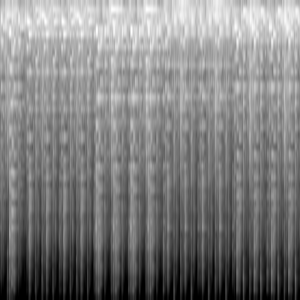

In [7]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, data.loc[test_idx, 'labels'], data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



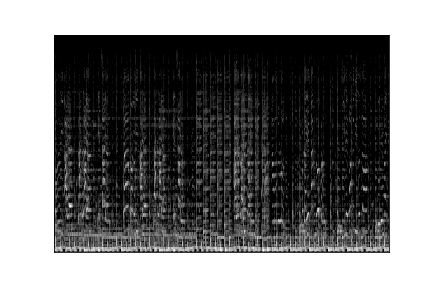

In [8]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [9]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,songs,labels,encoded_labels
0,039357.npy,039357.npy,Western_mel_numpy,1
1,107591.npy,107591.npy,Western_mel_numpy,1
2,143217.npy,143217.npy,Western_mel_numpy,1
3,140623.npy,140623.npy,Western_mel_numpy,1
4,147059.npy,147059.npy,Western_mel_numpy,1


In [10]:
classes = ('Indian_numpy', 'Western_numpy')
data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,2008,2008
Western_mel_numpy,1,2008,2008


In [11]:
from sklearn.model_selection import train_test_split

data = data.sample(frac=1)
df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,1405,1405
Western_mel_numpy,1,1406,1406


In [13]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,603,603
Western_mel_numpy,1,602,602


In [14]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [15]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return data, label



In [16]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [17]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [18]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    array = 255 - array
    array = np.transpose(array, (1, 2, 0))
    return array.squeeze()

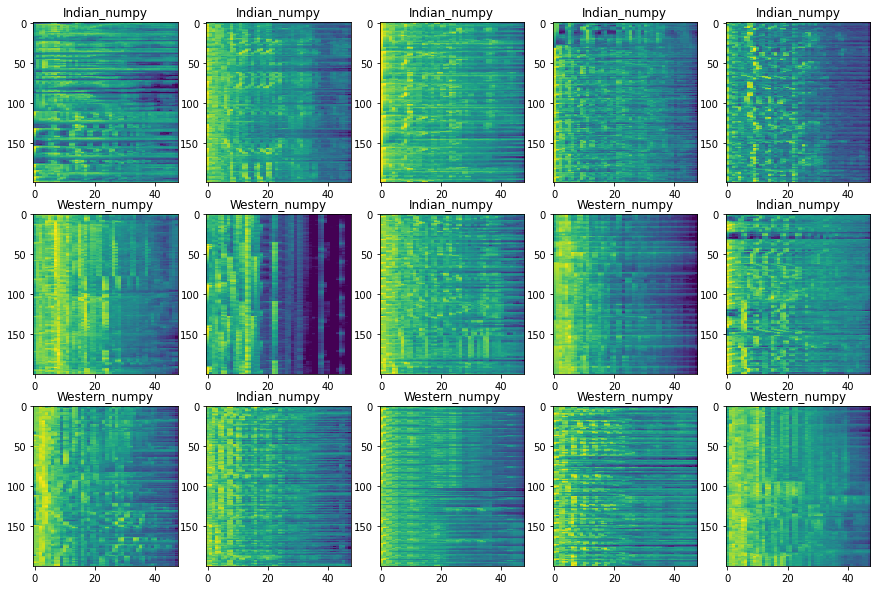

In [19]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

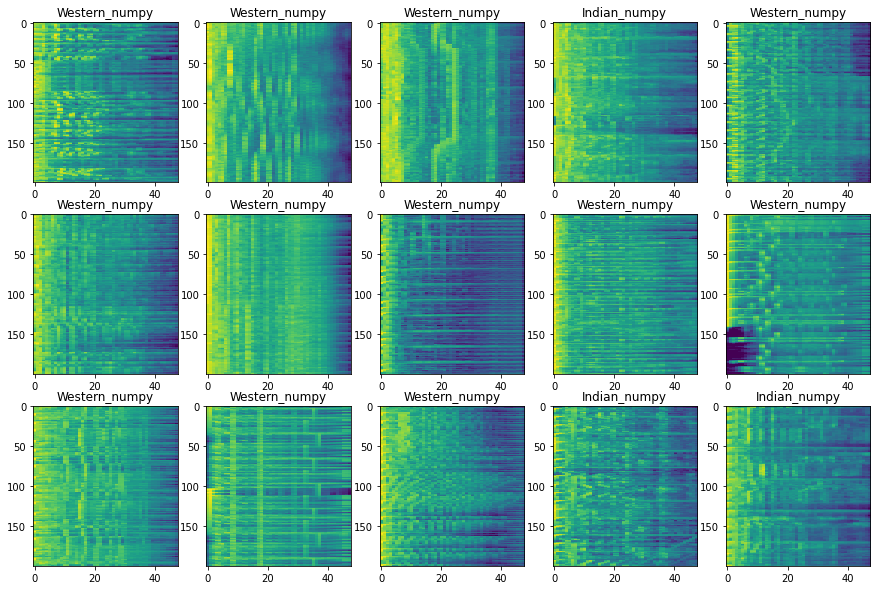

In [20]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [21]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return x

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [22]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1431.094
[1,     2] loss: 1230.291
[1,     3] loss: 1357.838
[1,     4] loss: 1120.761
[1,     5] loss: 1150.938
[1,     6] loss: 874.806
[1,     7] loss: 721.499
[1,     8] loss: 421.373
[1,     9] loss: 239.998
[1,    10] loss: 552.054
[1,    11] loss: 370.934
[1,    12] loss: 145.104
[1,    13] loss: 132.876
[1,    14] loss: 189.829
[1,    15] loss: 152.740
[1,    16] loss: 212.672
[1,    17] loss: 219.468
[1,    18] loss: 212.555
[1,    19] loss: 217.215
[1,    20] loss: 133.427
[1,    21] loss: 158.623
[1,    22] loss: 130.980
[1,    23] loss: 116.266
[1,    24] loss: 146.595
[1,    25] loss: 154.872
[1,    26] loss: 136.760
[1,    27] loss: 141.951
[1,    28] loss: 139.099
[1,    29] loss: 114.780
[1,    30] loss: 109.558
[1,    31] loss: 137.500
[1,    32] loss: 113.034
[1,    33] loss: 123.725
[1,    34] loss: 146.453
[1,    35] loss: 90.022
[1,    36] loss: 117.830
[1,    37] loss: 108.640
[1,    38] loss: 129.722
[1,    39] loss: 124.065
[1,    40] loss: 125.

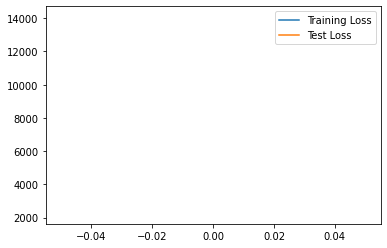

[2,     1] loss: 154.504
[2,     2] loss: 104.421
[2,     3] loss: 117.116
[2,     4] loss: 100.791
[2,     5] loss: 120.015
[2,     6] loss: 95.605
[2,     7] loss: 103.272
[2,     8] loss: 105.140
[2,     9] loss: 132.535
[2,    10] loss: 124.642
[2,    11] loss: 100.823
[2,    12] loss: 103.288
[2,    13] loss: 113.294
[2,    14] loss: 120.117
[2,    15] loss: 94.142
[2,    16] loss: 105.617
[2,    17] loss: 104.780
[2,    18] loss: 105.848
[2,    19] loss: 132.596
[2,    20] loss: 94.494
[2,    21] loss: 120.188
[2,    22] loss: 105.854
[2,    23] loss: 92.432
[2,    24] loss: 102.433
[2,    25] loss: 98.095
[2,    26] loss: 84.518
[2,    27] loss: 108.826
[2,    28] loss: 108.630
[2,    29] loss: 96.795
[2,    30] loss: 97.541
[2,    31] loss: 116.279
[2,    32] loss: 97.167
[2,    33] loss: 101.205
[2,    34] loss: 114.121
[2,    35] loss: 79.934
[2,    36] loss: 95.777
[2,    37] loss: 90.232
[2,    38] loss: 103.287
[2,    39] loss: 99.242
[2,    40] loss: 98.060
[2,    41] los

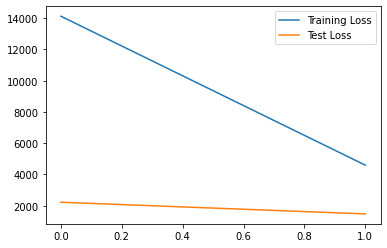

[3,     1] loss: 77.913
[3,     2] loss: 75.071
[3,     3] loss: 80.453
[3,     4] loss: 64.084
[3,     5] loss: 76.774
[3,     6] loss: 70.707
[3,     7] loss: 72.866
[3,     8] loss: 79.425
[3,     9] loss: 76.969
[3,    10] loss: 77.370
[3,    11] loss: 77.764
[3,    12] loss: 75.523
[3,    13] loss: 71.457
[3,    14] loss: 80.490
[3,    15] loss: 61.417
[3,    16] loss: 79.892
[3,    17] loss: 72.758
[3,    18] loss: 77.825
[3,    19] loss: 78.023
[3,    20] loss: 62.855
[3,    21] loss: 71.715
[3,    22] loss: 74.718
[3,    23] loss: 67.356
[3,    24] loss: 68.581
[3,    25] loss: 68.888
[3,    26] loss: 66.557
[3,    27] loss: 76.156
[3,    28] loss: 76.901
[3,    29] loss: 69.108
[3,    30] loss: 74.967
[3,    31] loss: 82.083
[3,    32] loss: 72.265
[3,    33] loss: 73.555
[3,    34] loss: 73.289
[3,    35] loss: 63.860
[3,    36] loss: 75.348
[3,    37] loss: 67.835
[3,    38] loss: 74.505
[3,    39] loss: 74.790
[3,    40] loss: 74.859
[3,    41] loss: 67.838
[3,    42] loss:

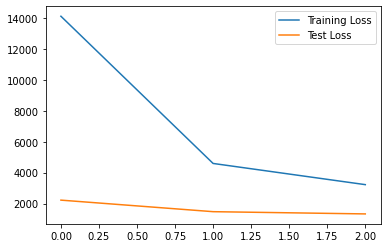

[4,     1] loss: 64.119
[4,     2] loss: 64.865
[4,     3] loss: 77.568
[4,     4] loss: 59.438
[4,     5] loss: 74.867
[4,     6] loss: 64.494
[4,     7] loss: 68.703
[4,     8] loss: 71.900
[4,     9] loss: 70.720
[4,    10] loss: 75.274
[4,    11] loss: 73.281
[4,    12] loss: 73.662
[4,    13] loss: 68.654
[4,    14] loss: 78.537
[4,    15] loss: 60.343
[4,    16] loss: 78.028
[4,    17] loss: 71.294
[4,    18] loss: 75.493
[4,    19] loss: 74.579
[4,    20] loss: 61.155
[4,    21] loss: 69.920
[4,    22] loss: 72.649
[4,    23] loss: 66.539
[4,    24] loss: 67.044
[4,    25] loss: 67.884
[4,    26] loss: 65.908
[4,    27] loss: 75.326
[4,    28] loss: 75.963
[4,    29] loss: 68.926
[4,    30] loss: 73.460
[4,    31] loss: 81.506
[4,    32] loss: 70.891
[4,    33] loss: 73.042
[4,    34] loss: 71.674
[4,    35] loss: 63.311
[4,    36] loss: 74.098
[4,    37] loss: 66.894
[4,    38] loss: 73.817
[4,    39] loss: 74.166
[4,    40] loss: 74.058
[4,    41] loss: 67.078
[4,    42] loss:

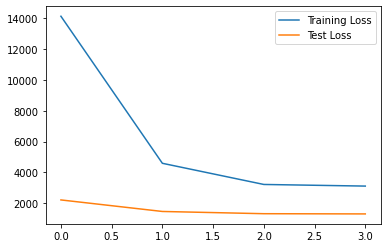

[5,     1] loss: 63.256
[5,     2] loss: 64.350
[5,     3] loss: 76.855
[5,     4] loss: 59.046
[5,     5] loss: 74.099
[5,     6] loss: 64.264
[5,     7] loss: 68.025
[5,     8] loss: 71.425
[5,     9] loss: 70.169
[5,    10] loss: 74.491
[5,    11] loss: 72.647
[5,    12] loss: 72.988
[5,    13] loss: 68.018
[5,    14] loss: 77.919
[5,    15] loss: 59.900
[5,    16] loss: 77.536
[5,    17] loss: 70.458
[5,    18] loss: 74.790
[5,    19] loss: 73.430
[5,    20] loss: 60.821
[5,    21] loss: 69.088
[5,    22] loss: 72.350
[5,    23] loss: 65.694
[5,    24] loss: 66.627
[5,    25] loss: 66.907
[5,    26] loss: 65.786
[5,    27] loss: 74.733
[5,    28] loss: 75.492
[5,    29] loss: 67.754
[5,    30] loss: 73.030
[5,    31] loss: 80.379
[5,    32] loss: 70.603
[5,    33] loss: 72.096
[5,    34] loss: 71.488
[5,    35] loss: 63.169
[5,    36] loss: 73.794
[5,    37] loss: 66.927
[5,    38] loss: 73.401
[5,    39] loss: 73.559
[5,    40] loss: 73.586
[5,    41] loss: 66.535
[5,    42] loss:

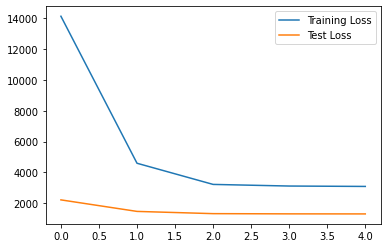

[6,     1] loss: 62.951
[6,     2] loss: 63.873
[6,     3] loss: 76.714
[6,     4] loss: 58.793
[6,     5] loss: 73.751
[6,     6] loss: 63.875
[6,     7] loss: 67.742
[6,     8] loss: 71.196
[6,     9] loss: 69.951
[6,    10] loss: 74.008
[6,    11] loss: 72.098
[6,    12] loss: 72.416
[6,    13] loss: 67.617
[6,    14] loss: 77.451
[6,    15] loss: 59.617
[6,    16] loss: 77.552
[6,    17] loss: 70.554
[6,    18] loss: 74.407
[6,    19] loss: 74.103
[6,    20] loss: 60.469
[6,    21] loss: 69.358
[6,    22] loss: 72.167
[6,    23] loss: 65.676
[6,    24] loss: 66.342
[6,    25] loss: 66.487
[6,    26] loss: 65.839
[6,    27] loss: 74.580
[6,    28] loss: 75.337
[6,    29] loss: 67.114
[6,    30] loss: 72.767
[6,    31] loss: 79.716
[6,    32] loss: 70.401
[6,    33] loss: 71.636
[6,    34] loss: 71.191
[6,    35] loss: 62.992
[6,    36] loss: 73.453
[6,    37] loss: 66.739
[6,    38] loss: 72.984
[6,    39] loss: 73.348
[6,    40] loss: 73.177
[6,    41] loss: 66.155
[6,    42] loss:

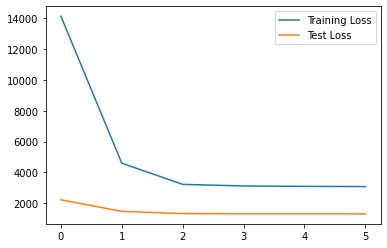

[7,     1] loss: 62.661
[7,     2] loss: 63.606
[7,     3] loss: 76.394
[7,     4] loss: 58.525
[7,     5] loss: 73.385
[7,     6] loss: 63.567
[7,     7] loss: 67.454
[7,     8] loss: 70.809
[7,     9] loss: 69.873
[7,    10] loss: 73.428
[7,    11] loss: 71.514
[7,    12] loss: 71.691
[7,    13] loss: 67.115
[7,    14] loss: 76.960
[7,    15] loss: 59.306
[7,    16] loss: 77.337
[7,    17] loss: 69.918
[7,    18] loss: 74.116
[7,    19] loss: 73.797
[7,    20] loss: 60.053
[7,    21] loss: 68.970
[7,    22] loss: 71.567
[7,    23] loss: 65.357
[7,    24] loss: 65.440
[7,    25] loss: 66.015
[7,    26] loss: 65.306
[7,    27] loss: 74.456
[7,    28] loss: 74.643
[7,    29] loss: 66.650
[7,    30] loss: 71.917
[7,    31] loss: 79.128
[7,    32] loss: 69.875
[7,    33] loss: 71.159
[7,    34] loss: 70.799
[7,    35] loss: 62.450
[7,    36] loss: 73.165
[7,    37] loss: 66.098
[7,    38] loss: 72.585
[7,    39] loss: 72.909
[7,    40] loss: 72.848
[7,    41] loss: 65.555
[7,    42] loss:

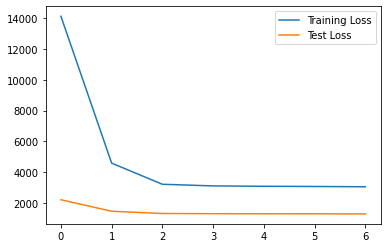

[8,     1] loss: 62.352
[8,     2] loss: 63.340
[8,     3] loss: 75.872
[8,     4] loss: 58.176
[8,     5] loss: 72.929
[8,     6] loss: 63.197
[8,     7] loss: 67.085
[8,     8] loss: 70.287
[8,     9] loss: 69.747
[8,    10] loss: 72.626
[8,    11] loss: 70.830
[8,    12] loss: 70.644
[8,    13] loss: 66.555
[8,    14] loss: 76.209
[8,    15] loss: 58.957
[8,    16] loss: 76.782
[8,    17] loss: 69.201
[8,    18] loss: 73.503
[8,    19] loss: 73.308
[8,    20] loss: 59.586
[8,    21] loss: 68.349
[8,    22] loss: 71.080
[8,    23] loss: 64.658
[8,    24] loss: 64.766
[8,    25] loss: 65.123
[8,    26] loss: 64.936
[8,    27] loss: 73.838
[8,    28] loss: 73.761
[8,    29] loss: 65.541
[8,    30] loss: 71.022
[8,    31] loss: 78.213
[8,    32] loss: 69.119
[8,    33] loss: 70.393
[8,    34] loss: 69.967
[8,    35] loss: 62.038
[8,    36] loss: 72.192
[8,    37] loss: 65.797
[8,    38] loss: 71.803
[8,    39] loss: 72.193
[8,    40] loss: 72.034
[8,    41] loss: 64.584
[8,    42] loss:

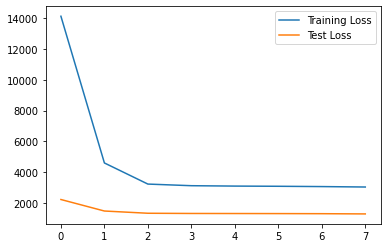

[9,     1] loss: 61.643
[9,     2] loss: 62.713
[9,     3] loss: 74.629
[9,     4] loss: 57.646
[9,     5] loss: 72.002
[9,     6] loss: 62.752
[9,     7] loss: 66.130
[9,     8] loss: 69.662
[9,     9] loss: 69.108
[9,    10] loss: 71.518
[9,    11] loss: 69.721
[9,    12] loss: 69.019
[9,    13] loss: 65.693
[9,    14] loss: 74.763
[9,    15] loss: 58.375
[9,    16] loss: 75.475
[9,    17] loss: 68.628
[9,    18] loss: 71.960
[9,    19] loss: 72.808
[9,    20] loss: 59.058
[9,    21] loss: 67.134
[9,    22] loss: 71.179
[9,    23] loss: 62.938
[9,    24] loss: 65.042
[9,    25] loss: 63.323
[9,    26] loss: 64.828
[9,    27] loss: 72.045
[9,    28] loss: 71.781
[9,    29] loss: 63.537
[9,    30] loss: 69.295
[9,    31] loss: 77.227
[9,    32] loss: 67.343
[9,    33] loss: 68.852
[9,    34] loss: 67.589
[9,    35] loss: 61.245
[9,    36] loss: 69.544
[9,    37] loss: 64.423
[9,    38] loss: 70.809
[9,    39] loss: 70.596
[9,    40] loss: 70.119
[9,    41] loss: 62.595
[9,    42] loss:

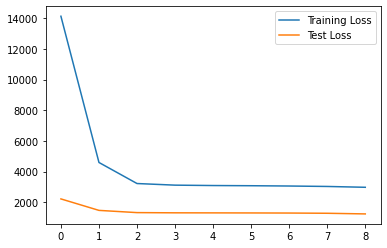

[10,     1] loss: 59.696
[10,     2] loss: 61.447
[10,     3] loss: 70.833
[10,     4] loss: 55.512
[10,     5] loss: 69.889
[10,     6] loss: 61.465
[10,     7] loss: 64.047
[10,     8] loss: 67.032
[10,     9] loss: 66.712
[10,    10] loss: 68.313
[10,    11] loss: 66.556
[10,    12] loss: 64.619
[10,    13] loss: 62.689
[10,    14] loss: 69.816
[10,    15] loss: 56.032
[10,    16] loss: 70.615
[10,    17] loss: 64.956
[10,    18] loss: 68.474
[10,    19] loss: 67.318
[10,    20] loss: 59.125
[10,    21] loss: 62.751
[10,    22] loss: 65.531
[10,    23] loss: 59.744
[10,    24] loss: 58.862
[10,    25] loss: 59.713
[10,    26] loss: 62.251
[10,    27] loss: 64.537
[10,    28] loss: 63.056
[10,    29] loss: 57.732
[10,    30] loss: 64.267
[10,    31] loss: 69.131
[10,    32] loss: 62.031
[10,    33] loss: 63.489
[10,    34] loss: 63.338
[10,    35] loss: 57.387
[10,    36] loss: 64.621
[10,    37] loss: 62.590
[10,    38] loss: 62.442
[10,    39] loss: 63.939
[10,    40] loss: 65.793


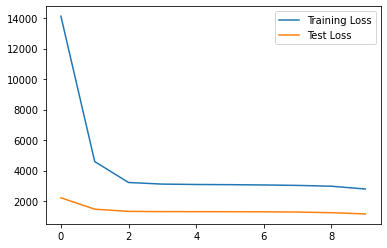

[11,     1] loss: 56.522
[11,     2] loss: 57.513
[11,     3] loss: 63.634
[11,     4] loss: 51.423
[11,     5] loss: 66.339
[11,     6] loss: 59.588
[11,     7] loss: 59.777
[11,     8] loss: 63.052
[11,     9] loss: 63.187
[11,    10] loss: 63.583
[11,    11] loss: 61.863
[11,    12] loss: 60.989
[11,    13] loss: 60.696
[11,    14] loss: 64.712
[11,    15] loss: 54.841
[11,    16] loss: 66.325
[11,    17] loss: 61.852
[11,    18] loss: 64.660
[11,    19] loss: 62.949
[11,    20] loss: 54.419
[11,    21] loss: 57.773
[11,    22] loss: 61.861
[11,    23] loss: 55.186
[11,    24] loss: 55.736
[11,    25] loss: 55.769
[11,    26] loss: 57.650
[11,    27] loss: 60.310
[11,    28] loss: 58.682
[11,    29] loss: 54.417
[11,    30] loss: 62.131
[11,    31] loss: 66.274
[11,    32] loss: 60.295
[11,    33] loss: 61.033
[11,    34] loss: 60.528
[11,    35] loss: 55.797
[11,    36] loss: 61.527
[11,    37] loss: 60.274
[11,    38] loss: 60.166
[11,    39] loss: 61.597
[11,    40] loss: 63.971


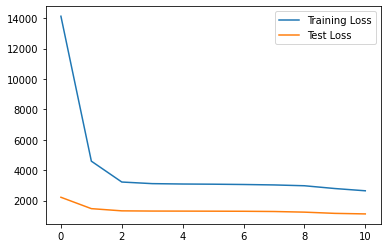

[12,     1] loss: 54.394
[12,     2] loss: 55.996
[12,     3] loss: 61.609
[12,     4] loss: 50.352
[12,     5] loss: 64.367
[12,     6] loss: 58.281
[12,     7] loss: 58.426
[12,     8] loss: 61.175
[12,     9] loss: 62.176
[12,    10] loss: 61.675
[12,    11] loss: 59.977
[12,    12] loss: 58.641
[12,    13] loss: 59.540
[12,    14] loss: 62.574
[12,    15] loss: 53.544
[12,    16] loss: 64.908
[12,    17] loss: 60.765
[12,    18] loss: 64.040
[12,    19] loss: 60.140
[12,    20] loss: 53.453
[12,    21] loss: 56.792
[12,    22] loss: 59.952
[12,    23] loss: 54.020
[12,    24] loss: 54.231
[12,    25] loss: 54.262
[12,    26] loss: 56.354
[12,    27] loss: 59.206
[12,    28] loss: 57.096
[12,    29] loss: 53.178
[12,    30] loss: 61.248
[12,    31] loss: 64.103
[12,    32] loss: 58.605
[12,    33] loss: 59.822
[12,    34] loss: 59.021
[12,    35] loss: 54.722
[12,    36] loss: 60.047
[12,    37] loss: 58.813
[12,    38] loss: 59.187
[12,    39] loss: 59.930
[12,    40] loss: 62.125


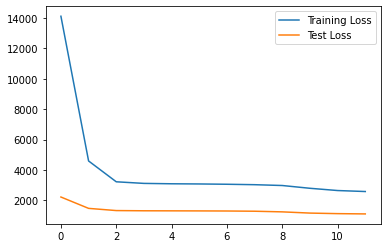

[13,     1] loss: 53.562
[13,     2] loss: 54.741
[13,     3] loss: 60.702
[13,     4] loss: 49.395
[13,     5] loss: 62.881
[13,     6] loss: 57.780
[13,     7] loss: 57.259
[13,     8] loss: 60.159
[13,     9] loss: 61.162
[13,    10] loss: 59.588
[13,    11] loss: 58.879
[13,    12] loss: 56.526
[13,    13] loss: 57.771
[13,    14] loss: 60.782
[13,    15] loss: 50.832
[13,    16] loss: 63.450
[13,    17] loss: 58.710
[13,    18] loss: 61.925
[13,    19] loss: 57.484
[13,    20] loss: 51.955
[13,    21] loss: 55.887
[13,    22] loss: 58.519
[13,    23] loss: 52.774
[13,    24] loss: 53.311
[13,    25] loss: 52.966
[13,    26] loss: 55.020
[13,    27] loss: 57.069
[13,    28] loss: 54.987
[13,    29] loss: 51.936
[13,    30] loss: 60.024
[13,    31] loss: 61.889
[13,    32] loss: 57.873
[13,    33] loss: 58.390
[13,    34] loss: 57.591
[13,    35] loss: 53.802
[13,    36] loss: 58.581
[13,    37] loss: 58.235
[13,    38] loss: 57.047
[13,    39] loss: 58.946
[13,    40] loss: 59.959


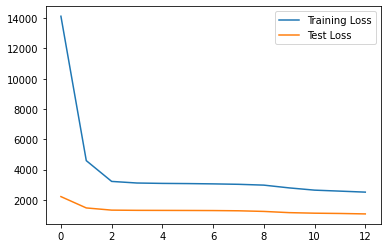

[14,     1] loss: 52.555
[14,     2] loss: 54.459
[14,     3] loss: 61.225
[14,     4] loss: 50.841
[14,     5] loss: 60.954
[14,     6] loss: 56.526
[14,     7] loss: 57.476
[14,     8] loss: 57.711
[14,     9] loss: 61.069
[14,    10] loss: 58.729
[14,    11] loss: 57.232
[14,    12] loss: 55.237
[14,    13] loss: 55.101
[14,    14] loss: 58.082
[14,    15] loss: 49.289
[14,    16] loss: 59.739
[14,    17] loss: 57.705
[14,    18] loss: 58.833
[14,    19] loss: 54.396
[14,    20] loss: 50.889
[14,    21] loss: 53.666
[14,    22] loss: 57.890
[14,    23] loss: 51.887
[14,    24] loss: 51.735
[14,    25] loss: 52.619
[14,    26] loss: 53.129
[14,    27] loss: 54.260
[14,    28] loss: 52.644
[14,    29] loss: 50.623
[14,    30] loss: 57.791
[14,    31] loss: 59.983
[14,    32] loss: 55.402
[14,    33] loss: 56.657
[14,    34] loss: 55.272
[14,    35] loss: 52.557
[14,    36] loss: 55.976
[14,    37] loss: 57.170
[14,    38] loss: 54.868
[14,    39] loss: 56.751
[14,    40] loss: 56.732


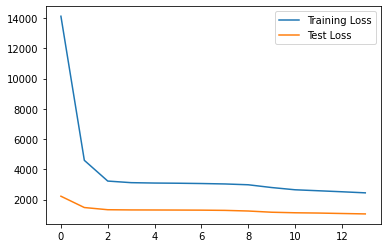

[15,     1] loss: 51.223
[15,     2] loss: 52.117
[15,     3] loss: 57.591
[15,     4] loss: 47.823
[15,     5] loss: 58.229
[15,     6] loss: 55.423
[15,     7] loss: 53.137
[15,     8] loss: 55.651
[15,     9] loss: 58.350
[15,    10] loss: 56.453
[15,    11] loss: 54.928
[15,    12] loss: 52.039
[15,    13] loss: 53.507
[15,    14] loss: 55.971
[15,    15] loss: 48.522
[15,    16] loss: 58.123
[15,    17] loss: 55.502
[15,    18] loss: 57.712
[15,    19] loss: 51.764
[15,    20] loss: 48.871
[15,    21] loss: 52.408
[15,    22] loss: 55.462
[15,    23] loss: 49.858
[15,    24] loss: 49.830
[15,    25] loss: 50.459
[15,    26] loss: 50.856
[15,    27] loss: 52.520
[15,    28] loss: 51.624
[15,    29] loss: 48.894
[15,    30] loss: 56.787
[15,    31] loss: 57.838
[15,    32] loss: 53.363
[15,    33] loss: 55.106
[15,    34] loss: 53.527
[15,    35] loss: 51.619
[15,    36] loss: 54.125
[15,    37] loss: 56.008
[15,    38] loss: 53.648
[15,    39] loss: 54.699
[15,    40] loss: 54.895


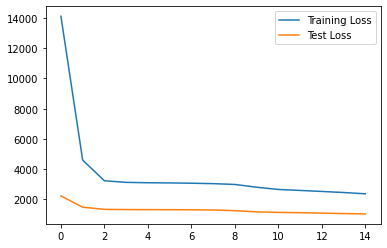

[16,     1] loss: 49.741
[16,     2] loss: 50.615
[16,     3] loss: 56.072
[16,     4] loss: 46.165
[16,     5] loss: 56.612
[16,     6] loss: 53.996
[16,     7] loss: 51.442
[16,     8] loss: 54.621
[16,     9] loss: 56.526
[16,    10] loss: 55.370
[16,    11] loss: 53.588
[16,    12] loss: 50.609
[16,    13] loss: 52.577
[16,    14] loss: 54.762
[16,    15] loss: 48.154
[16,    16] loss: 57.127
[16,    17] loss: 54.527
[16,    18] loss: 56.860
[16,    19] loss: 50.332
[16,    20] loss: 48.070
[16,    21] loss: 51.140
[16,    22] loss: 54.236
[16,    23] loss: 48.860
[16,    24] loss: 48.624
[16,    25] loss: 49.395
[16,    26] loss: 49.980
[16,    27] loss: 51.664
[16,    28] loss: 50.394
[16,    29] loss: 47.835
[16,    30] loss: 55.610
[16,    31] loss: 55.956
[16,    32] loss: 52.373
[16,    33] loss: 53.770
[16,    34] loss: 52.427
[16,    35] loss: 50.403
[16,    36] loss: 53.155
[16,    37] loss: 54.981
[16,    38] loss: 52.501
[16,    39] loss: 53.020
[16,    40] loss: 53.570


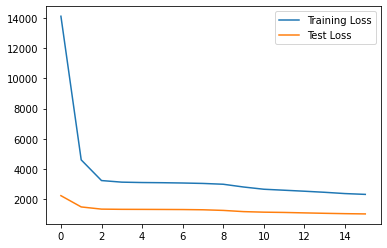

[17,     1] loss: 48.779
[17,     2] loss: 49.582
[17,     3] loss: 55.095
[17,     4] loss: 45.547
[17,     5] loss: 55.461
[17,     6] loss: 53.244
[17,     7] loss: 50.533
[17,     8] loss: 53.964
[17,     9] loss: 55.228
[17,    10] loss: 54.722
[17,    11] loss: 52.462
[17,    12] loss: 49.711
[17,    13] loss: 51.900
[17,    14] loss: 53.687
[17,    15] loss: 47.808
[17,    16] loss: 56.188
[17,    17] loss: 53.518
[17,    18] loss: 55.684
[17,    19] loss: 49.056
[17,    20] loss: 47.288
[17,    21] loss: 50.153
[17,    22] loss: 53.303
[17,    23] loss: 47.850
[17,    24] loss: 47.818
[17,    25] loss: 48.324
[17,    26] loss: 49.516
[17,    27] loss: 50.815
[17,    28] loss: 49.448
[17,    29] loss: 47.005
[17,    30] loss: 54.563
[17,    31] loss: 54.361
[17,    32] loss: 51.785
[17,    33] loss: 52.631
[17,    34] loss: 51.628
[17,    35] loss: 49.277
[17,    36] loss: 52.528
[17,    37] loss: 54.135
[17,    38] loss: 51.303
[17,    39] loss: 51.826
[17,    40] loss: 52.390


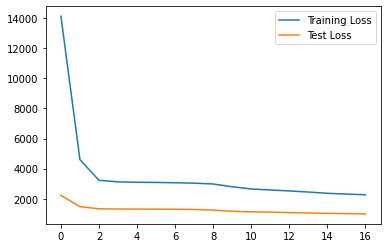

[18,     1] loss: 47.582
[18,     2] loss: 48.150
[18,     3] loss: 53.798
[18,     4] loss: 44.094
[18,     5] loss: 54.308
[18,     6] loss: 52.194
[18,     7] loss: 49.141
[18,     8] loss: 53.218
[18,     9] loss: 53.642
[18,    10] loss: 53.760
[18,    11] loss: 51.407
[18,    12] loss: 48.566
[18,    13] loss: 51.164
[18,    14] loss: 52.338
[18,    15] loss: 47.707
[18,    16] loss: 54.630
[18,    17] loss: 52.981
[18,    18] loss: 53.951
[18,    19] loss: 49.033
[18,    20] loss: 45.865
[18,    21] loss: 48.987
[18,    22] loss: 52.323
[18,    23] loss: 46.400
[18,    24] loss: 47.069
[18,    25] loss: 47.301
[18,    26] loss: 48.888
[18,    27] loss: 49.526
[18,    28] loss: 48.774
[18,    29] loss: 45.854
[18,    30] loss: 53.102
[18,    31] loss: 53.021
[18,    32] loss: 50.234
[18,    33] loss: 51.670
[18,    34] loss: 49.972
[18,    35] loss: 48.721
[18,    36] loss: 51.289
[18,    37] loss: 52.869
[18,    38] loss: 50.175
[18,    39] loss: 50.657
[18,    40] loss: 50.960


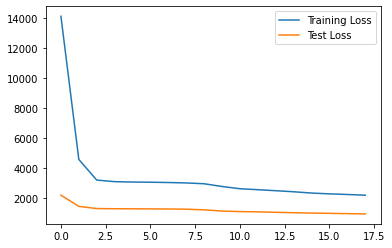

[19,     1] loss: 46.245
[19,     2] loss: 47.125
[19,     3] loss: 52.631
[19,     4] loss: 43.189
[19,     5] loss: 53.076
[19,     6] loss: 50.709
[19,     7] loss: 48.242
[19,     8] loss: 51.904
[19,     9] loss: 51.928
[19,    10] loss: 52.760
[19,    11] loss: 49.869
[19,    12] loss: 47.798
[19,    13] loss: 49.736
[19,    14] loss: 51.802
[19,    15] loss: 46.205
[19,    16] loss: 53.963
[19,    17] loss: 51.185
[19,    18] loss: 53.201
[19,    19] loss: 47.429
[19,    20] loss: 45.261
[19,    21] loss: 47.718
[19,    22] loss: 51.309
[19,    23] loss: 45.530
[19,    24] loss: 46.273
[19,    25] loss: 46.640
[19,    26] loss: 47.896
[19,    27] loss: 48.932
[19,    28] loss: 48.002
[19,    29] loss: 44.926
[19,    30] loss: 52.406
[19,    31] loss: 51.961
[19,    32] loss: 49.684
[19,    33] loss: 50.642
[19,    34] loss: 49.211
[19,    35] loss: 47.727
[19,    36] loss: 50.545
[19,    37] loss: 51.666
[19,    38] loss: 49.342
[19,    39] loss: 49.650
[19,    40] loss: 50.176


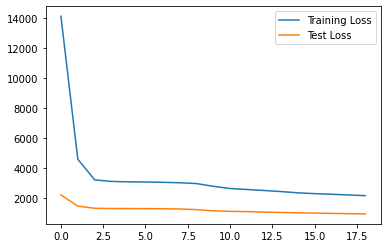

[20,     1] loss: 45.289
[20,     2] loss: 46.742
[20,     3] loss: 51.747
[20,     4] loss: 42.844
[20,     5] loss: 52.329
[20,     6] loss: 49.692
[20,     7] loss: 47.577
[20,     8] loss: 50.536
[20,     9] loss: 51.355
[20,    10] loss: 51.377
[20,    11] loss: 49.238
[20,    12] loss: 46.132
[20,    13] loss: 48.584
[20,    14] loss: 50.405
[20,    15] loss: 44.827
[20,    16] loss: 52.637
[20,    17] loss: 50.134
[20,    18] loss: 51.972
[20,    19] loss: 46.659
[20,    20] loss: 44.024
[20,    21] loss: 46.850
[20,    22] loss: 50.363
[20,    23] loss: 44.693
[20,    24] loss: 45.618
[20,    25] loss: 45.716
[20,    26] loss: 46.680
[20,    27] loss: 47.727
[20,    28] loss: 46.752
[20,    29] loss: 43.795
[20,    30] loss: 51.371
[20,    31] loss: 50.691
[20,    32] loss: 48.907
[20,    33] loss: 49.265
[20,    34] loss: 48.137
[20,    35] loss: 46.457
[20,    36] loss: 49.091
[20,    37] loss: 50.674
[20,    38] loss: 48.165
[20,    39] loss: 48.972
[20,    40] loss: 48.873


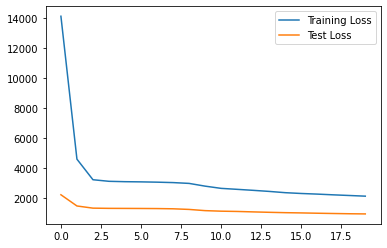

[21,     1] loss: 44.557
[21,     2] loss: 45.873
[21,     3] loss: 50.664
[21,     4] loss: 41.936
[21,     5] loss: 51.512
[21,     6] loss: 48.423
[21,     7] loss: 46.385
[21,     8] loss: 49.630
[21,     9] loss: 50.065
[21,    10] loss: 49.933
[21,    11] loss: 47.869
[21,    12] loss: 45.371
[21,    13] loss: 47.216
[21,    14] loss: 49.264
[21,    15] loss: 43.994
[21,    16] loss: 51.265
[21,    17] loss: 49.093
[21,    18] loss: 50.791
[21,    19] loss: 45.614
[21,    20] loss: 43.214
[21,    21] loss: 45.939
[21,    22] loss: 49.509
[21,    23] loss: 43.819
[21,    24] loss: 44.778
[21,    25] loss: 44.902
[21,    26] loss: 45.752
[21,    27] loss: 46.759
[21,    28] loss: 46.005
[21,    29] loss: 42.941
[21,    30] loss: 50.596
[21,    31] loss: 49.739
[21,    32] loss: 47.927
[21,    33] loss: 48.612
[21,    34] loss: 46.938
[21,    35] loss: 45.980
[21,    36] loss: 48.259
[21,    37] loss: 49.879
[21,    38] loss: 47.150
[21,    39] loss: 47.772
[21,    40] loss: 48.087


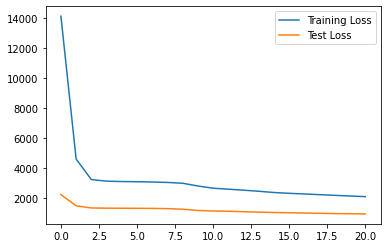

[22,     1] loss: 43.785
[22,     2] loss: 44.856
[22,     3] loss: 49.706
[22,     4] loss: 41.457
[22,     5] loss: 50.546
[22,     6] loss: 47.714
[22,     7] loss: 45.664
[22,     8] loss: 48.926
[22,     9] loss: 48.907
[22,    10] loss: 49.120
[22,    11] loss: 47.142
[22,    12] loss: 44.198
[22,    13] loss: 46.418
[22,    14] loss: 48.450
[22,    15] loss: 43.197
[22,    16] loss: 50.347
[22,    17] loss: 48.583
[22,    18] loss: 49.912
[22,    19] loss: 44.533
[22,    20] loss: 42.491
[22,    21] loss: 45.251
[22,    22] loss: 48.654
[22,    23] loss: 43.169
[22,    24] loss: 43.833
[22,    25] loss: 44.339
[22,    26] loss: 44.903
[22,    27] loss: 45.764
[22,    28] loss: 45.175
[22,    29] loss: 42.145
[22,    30] loss: 49.838
[22,    31] loss: 48.571
[22,    32] loss: 47.223
[22,    33] loss: 47.557
[22,    34] loss: 45.961
[22,    35] loss: 45.224
[22,    36] loss: 47.448
[22,    37] loss: 48.932
[22,    38] loss: 46.184
[22,    39] loss: 47.055
[22,    40] loss: 47.216


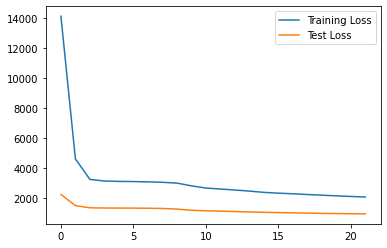

[23,     1] loss: 43.102
[23,     2] loss: 44.011
[23,     3] loss: 48.936
[23,     4] loss: 40.771
[23,     5] loss: 49.636
[23,     6] loss: 46.930
[23,     7] loss: 44.836
[23,     8] loss: 47.860
[23,     9] loss: 48.046
[23,    10] loss: 48.769
[23,    11] loss: 46.416
[23,    12] loss: 43.184
[23,    13] loss: 45.991
[23,    14] loss: 47.346
[23,    15] loss: 42.549
[23,    16] loss: 49.630
[23,    17] loss: 47.807
[23,    18] loss: 48.914
[23,    19] loss: 43.705
[23,    20] loss: 41.904
[23,    21] loss: 44.448
[23,    22] loss: 47.884
[23,    23] loss: 42.610
[23,    24] loss: 42.933
[23,    25] loss: 43.512
[23,    26] loss: 44.064
[23,    27] loss: 44.978
[23,    28] loss: 44.128
[23,    29] loss: 41.456
[23,    30] loss: 49.077
[23,    31] loss: 47.682
[23,    32] loss: 46.640
[23,    33] loss: 46.454
[23,    34] loss: 45.290
[23,    35] loss: 44.494
[23,    36] loss: 46.788
[23,    37] loss: 47.962
[23,    38] loss: 45.202
[23,    39] loss: 46.072
[23,    40] loss: 46.532


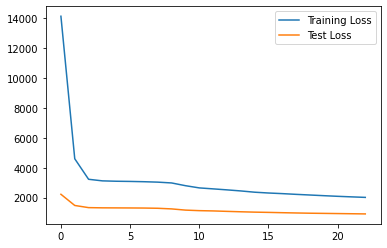

[24,     1] loss: 42.434
[24,     2] loss: 43.263
[24,     3] loss: 48.008
[24,     4] loss: 40.215
[24,     5] loss: 48.838
[24,     6] loss: 46.274
[24,     7] loss: 44.186
[24,     8] loss: 47.025
[24,     9] loss: 47.277
[24,    10] loss: 47.885
[24,    11] loss: 45.744
[24,    12] loss: 42.282
[24,    13] loss: 45.181
[24,    14] loss: 46.329
[24,    15] loss: 41.999
[24,    16] loss: 48.723
[24,    17] loss: 47.186
[24,    18] loss: 48.207
[24,    19] loss: 42.830
[24,    20] loss: 41.304
[24,    21] loss: 43.756
[24,    22] loss: 46.938
[24,    23] loss: 41.902
[24,    24] loss: 42.083
[24,    25] loss: 42.612
[24,    26] loss: 43.320
[24,    27] loss: 44.270
[24,    28] loss: 43.312
[24,    29] loss: 40.787
[24,    30] loss: 48.317
[24,    31] loss: 47.055
[24,    32] loss: 45.812
[24,    33] loss: 45.771
[24,    34] loss: 44.607
[24,    35] loss: 43.801
[24,    36] loss: 46.206
[24,    37] loss: 47.181
[24,    38] loss: 44.461
[24,    39] loss: 45.115
[24,    40] loss: 45.832


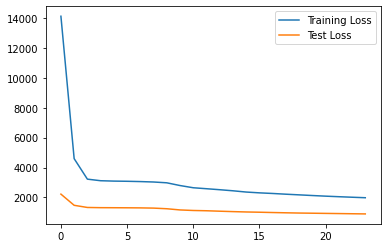

[25,     1] loss: 41.740
[25,     2] loss: 42.656
[25,     3] loss: 47.206
[25,     4] loss: 39.891
[25,     5] loss: 48.198
[25,     6] loss: 45.752
[25,     7] loss: 43.694
[25,     8] loss: 46.348
[25,     9] loss: 46.764
[25,    10] loss: 47.273
[25,    11] loss: 45.415
[25,    12] loss: 41.482
[25,    13] loss: 44.639
[25,    14] loss: 45.518
[25,    15] loss: 41.535
[25,    16] loss: 48.052
[25,    17] loss: 46.433
[25,    18] loss: 47.731
[25,    19] loss: 42.059
[25,    20] loss: 40.850
[25,    21] loss: 43.155
[25,    22] loss: 46.176
[25,    23] loss: 41.312
[25,    24] loss: 41.476
[25,    25] loss: 41.947
[25,    26] loss: 42.595
[25,    27] loss: 43.642
[25,    28] loss: 42.771
[25,    29] loss: 40.166
[25,    30] loss: 47.691
[25,    31] loss: 46.359
[25,    32] loss: 45.139
[25,    33] loss: 44.948
[25,    34] loss: 43.895
[25,    35] loss: 43.207
[25,    36] loss: 45.299
[25,    37] loss: 46.421
[25,    38] loss: 43.552
[25,    39] loss: 44.129
[25,    40] loss: 44.855


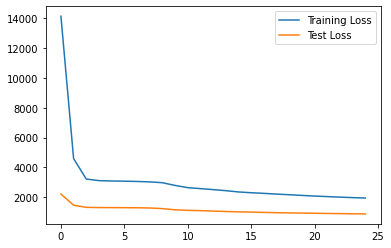

[26,     1] loss: 41.248
[26,     2] loss: 41.897
[26,     3] loss: 46.347
[26,     4] loss: 39.537
[26,     5] loss: 47.505
[26,     6] loss: 45.044
[26,     7] loss: 42.925
[26,     8] loss: 45.615
[26,     9] loss: 45.951
[26,    10] loss: 46.712
[26,    11] loss: 44.683
[26,    12] loss: 40.763
[26,    13] loss: 43.608
[26,    14] loss: 44.765
[26,    15] loss: 40.900
[26,    16] loss: 47.221
[26,    17] loss: 45.766
[26,    18] loss: 47.079
[26,    19] loss: 41.403
[26,    20] loss: 40.211
[26,    21] loss: 42.551
[26,    22] loss: 45.542
[26,    23] loss: 40.660
[26,    24] loss: 40.868
[26,    25] loss: 41.272
[26,    26] loss: 41.825
[26,    27] loss: 42.887
[26,    28] loss: 42.110
[26,    29] loss: 39.478
[26,    30] loss: 46.909
[26,    31] loss: 45.566
[26,    32] loss: 44.375
[26,    33] loss: 44.134
[26,    34] loss: 43.100
[26,    35] loss: 42.539
[26,    36] loss: 44.450
[26,    37] loss: 45.522
[26,    38] loss: 42.783
[26,    39] loss: 43.090
[26,    40] loss: 43.952


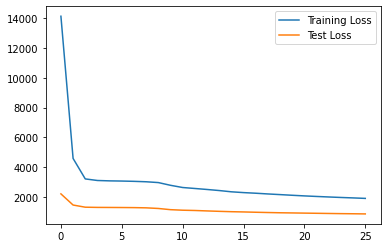

[27,     1] loss: 40.615
[27,     2] loss: 41.089
[27,     3] loss: 45.477
[27,     4] loss: 39.045
[27,     5] loss: 46.710
[27,     6] loss: 44.251
[27,     7] loss: 42.155
[27,     8] loss: 44.896
[27,     9] loss: 44.948
[27,    10] loss: 45.307
[27,    11] loss: 43.406
[27,    12] loss: 39.985
[27,    13] loss: 42.438
[27,    14] loss: 43.578
[27,    15] loss: 40.290
[27,    16] loss: 46.127
[27,    17] loss: 44.512
[27,    18] loss: 45.959
[27,    19] loss: 40.567
[27,    20] loss: 39.506
[27,    21] loss: 41.845
[27,    22] loss: 44.650
[27,    23] loss: 39.883
[27,    24] loss: 40.150
[27,    25] loss: 40.481
[27,    26] loss: 40.969
[27,    27] loss: 42.228
[27,    28] loss: 41.228
[27,    29] loss: 38.713
[27,    30] loss: 46.016
[27,    31] loss: 44.578
[27,    32] loss: 43.679
[27,    33] loss: 43.214
[27,    34] loss: 42.137
[27,    35] loss: 41.874
[27,    36] loss: 43.574
[27,    37] loss: 44.446
[27,    38] loss: 42.038
[27,    39] loss: 41.830
[27,    40] loss: 42.918


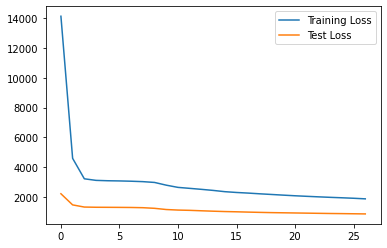

[28,     1] loss: 39.995
[28,     2] loss: 40.254
[28,     3] loss: 44.574
[28,     4] loss: 38.402
[28,     5] loss: 46.058
[28,     6] loss: 43.453
[28,     7] loss: 41.431
[28,     8] loss: 43.968
[28,     9] loss: 43.956
[28,    10] loss: 44.595
[28,    11] loss: 43.129
[28,    12] loss: 39.164
[28,    13] loss: 41.182
[28,    14] loss: 42.671
[28,    15] loss: 39.656
[28,    16] loss: 44.491
[28,    17] loss: 43.318
[28,    18] loss: 45.258
[28,    19] loss: 39.986
[28,    20] loss: 38.827
[28,    21] loss: 40.862
[28,    22] loss: 43.937
[28,    23] loss: 39.545
[28,    24] loss: 39.327
[28,    25] loss: 39.594
[28,    26] loss: 40.151
[28,    27] loss: 40.974
[28,    28] loss: 40.181
[28,    29] loss: 38.024
[28,    30] loss: 44.820
[28,    31] loss: 43.285
[28,    32] loss: 42.582
[28,    33] loss: 42.199
[28,    34] loss: 41.100
[28,    35] loss: 40.971
[28,    36] loss: 42.604
[28,    37] loss: 43.371
[28,    38] loss: 41.132
[28,    39] loss: 40.720
[28,    40] loss: 41.980


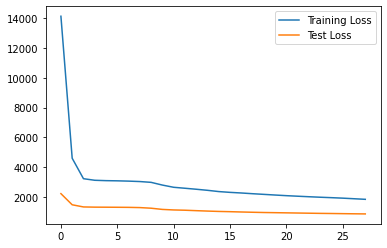

[29,     1] loss: 39.414
[29,     2] loss: 39.383
[29,     3] loss: 43.736
[29,     4] loss: 37.717
[29,     5] loss: 45.348
[29,     6] loss: 42.864
[29,     7] loss: 40.855
[29,     8] loss: 43.387
[29,     9] loss: 42.703
[29,    10] loss: 43.346
[29,    11] loss: 42.020
[29,    12] loss: 38.527
[29,    13] loss: 40.096
[29,    14] loss: 41.674
[29,    15] loss: 38.870
[29,    16] loss: 43.487
[29,    17] loss: 42.176
[29,    18] loss: 43.943
[29,    19] loss: 39.232
[29,    20] loss: 38.033
[29,    21] loss: 40.244
[29,    22] loss: 42.885
[29,    23] loss: 38.715
[29,    24] loss: 38.520
[29,    25] loss: 38.715
[29,    26] loss: 39.321
[29,    27] loss: 40.121
[29,    28] loss: 39.160
[29,    29] loss: 37.337
[29,    30] loss: 43.656
[29,    31] loss: 42.207
[29,    32] loss: 41.711
[29,    33] loss: 41.127
[29,    34] loss: 40.191
[29,    35] loss: 40.102
[29,    36] loss: 41.788
[29,    37] loss: 42.420
[29,    38] loss: 40.168
[29,    39] loss: 39.689
[29,    40] loss: 40.987


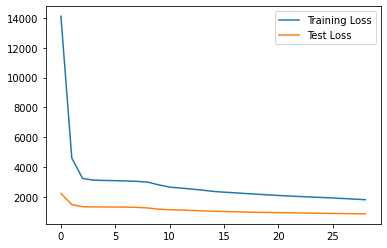

[30,     1] loss: 38.418
[30,     2] loss: 38.237
[30,     3] loss: 42.752
[30,     4] loss: 36.802
[30,     5] loss: 44.140
[30,     6] loss: 41.281
[30,     7] loss: 39.519
[30,     8] loss: 42.253
[30,     9] loss: 42.443
[30,    10] loss: 43.499
[30,    11] loss: 42.104
[30,    12] loss: 37.895
[30,    13] loss: 39.416
[30,    14] loss: 41.143
[30,    15] loss: 38.562
[30,    16] loss: 43.020
[30,    17] loss: 41.471
[30,    18] loss: 43.270
[30,    19] loss: 39.083
[30,    20] loss: 38.725
[30,    21] loss: 39.557
[30,    22] loss: 42.281
[30,    23] loss: 38.321
[30,    24] loss: 38.482
[30,    25] loss: 38.483
[30,    26] loss: 39.490
[30,    27] loss: 39.413
[30,    28] loss: 39.212
[30,    29] loss: 37.613
[30,    30] loss: 44.008
[30,    31] loss: 41.690
[30,    32] loss: 41.602
[30,    33] loss: 42.499
[30,    34] loss: 39.834
[30,    35] loss: 39.879
[30,    36] loss: 41.759
[30,    37] loss: 43.299
[30,    38] loss: 40.397
[30,    39] loss: 39.750
[30,    40] loss: 40.867


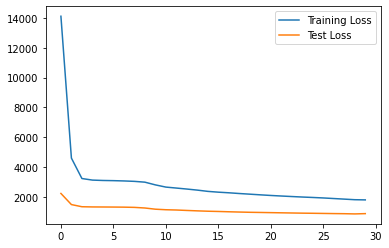

Finished Training


In [24]:
train_loss_graph = []
test_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)
          

print('Finished Training')

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image)
        ax.imshow(mel_display(output_img), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

Accuracy for class Indian_numpy is: 87.9 %
Accuracy for class Western_numpy is: 70.0 %
